# Bureau data
The goal of this Notebook is to aggregate data from Bureau and Bureau_balance, creating a feature with encoded information of client behavior.

In [194]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.plotting.register_matplotlib_converters()
%matplotlib inline

import duckdb


%load_ext autoreload
%autoreload 2
from help_tool import help_tool, help_visuals, help_stats, help_model

pd.set_option('future.no_silent_downcasting', True)

# Setting graph parameters
sns.set_theme(style='whitegrid')
sns.set_palette('husl')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Bureau Balance dataset
Dataset has information on monthly balances of previous credits in Credit Bureau. Dataset is made of 27 mill. observations and 3 features. No empty values or duplicates.

In [195]:
bureau_balance = help_tool.csv_download(
    r'Archive\home-credit-default-risk\bureau_balance.csv')

help_tool.first_look(bureau_balance)

Dataset has 27299925 observations and 3 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_BUREAU,int64,0,0.0
MONTHS_BALANCE,int64,0,0.0
STATUS,object,0,0.0


Dataset is big, sample of 100k would show the main distributions for EDA.

In [196]:
bureau_balance_sample = bureau_balance.sample(n=100000, random_state=42)

## EDA
### Categorical Feature
STATUS shows 'Months Past Due'. Where 'C' is 'closed' (agreement fulfilled) and X is 'unknown'. Most accounts are closed, but a minority is late on payments.

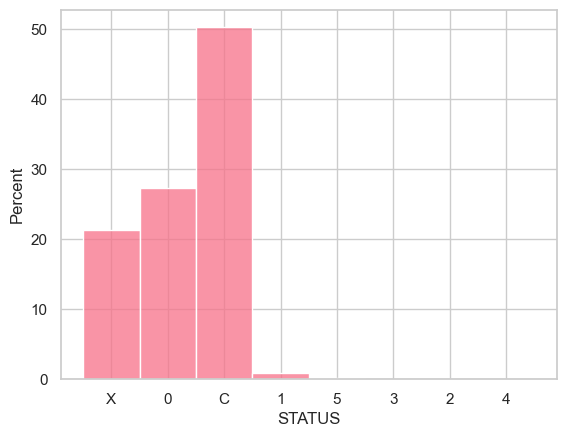

In [197]:
sns.histplot(data=bureau_balance_sample, x='STATUS', stat='percent')
plt.show()

The goal of this work is to find the relationships with defaulting. Thus, 'C' will be imputed with 0 (not missing).

In [198]:
bureau_balance['STATUS'] = bureau_balance['STATUS'].replace({'X': np.nan})

### Numerical Feature
Month balance range -96 months (time only relative to the application) to day of application.

MONTHS_BALANCE


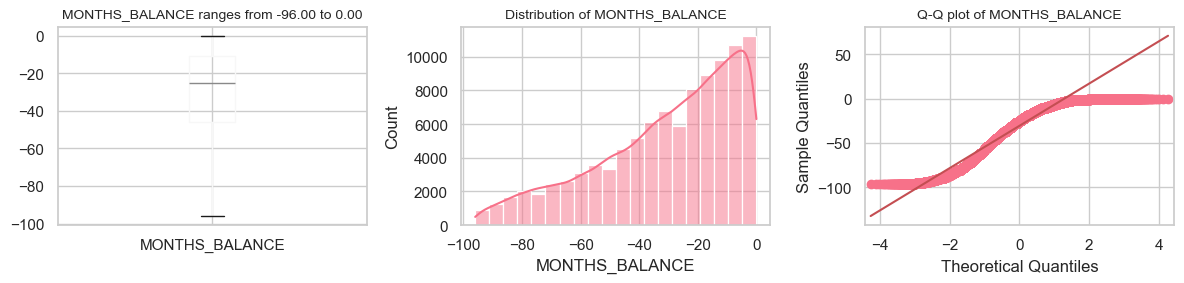

In [199]:
help_visuals.distribution_check(bureau_balance_sample[['MONTHS_BALANCE']])

Status can change over time, but not dramatically.

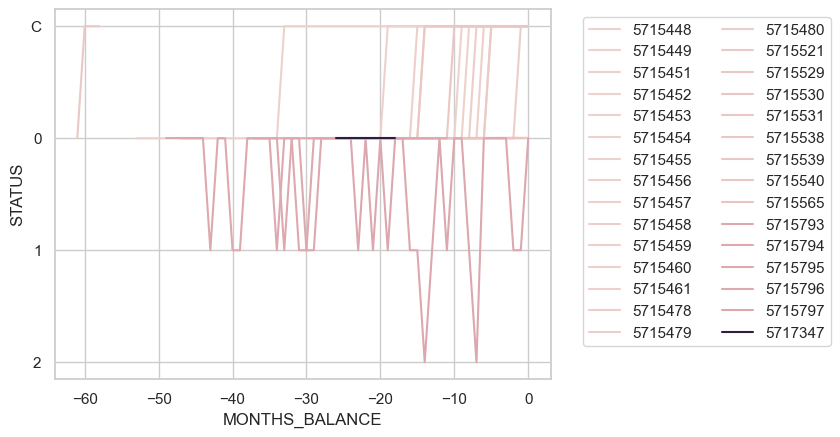

In [200]:
first_100_ids = bureau_balance['SK_ID_BUREAU'].drop_duplicates().head(30)
filtered_bureau_balance = bureau_balance[bureau_balance['SK_ID_BUREAU'].isin(
    first_100_ids)]

sns.lineplot(data=filtered_bureau_balance, x='MONTHS_BALANCE',
             y='STATUS', hue='SK_ID_BUREAU', legend='full')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)

plt.show()

## Feature Aggregation
bureau_balance mainly shows behavior of missing paying deadlines and the amount of time it takes to close the agreement.

In [201]:
status_change = help_tool.dummy_columns(bureau_balance.drop(columns='MONTHS_BALANCE'), 'STATUS').groupby(
    'SK_ID_BUREAU').sum(['0', '1', '2', '3', '4', '5', 'C']).reset_index()

In [202]:
bureau_balance_feature_matrix = duckdb.query("""
             WITH

             closed AS (
             SELECT MIN(MONTHS_BALANCE) AS Closed, SK_ID_BUREAU
             FROM bureau_balance
             WHERE STATUS = 'C'
             GROUP BY SK_ID_BUREAU
             )

             ,overall AS (
             SELECT MIN(MONTHS_BALANCE) AS Oveall, SK_ID_BUREAU
             FROM bureau_balance
             GROUP BY SK_ID_BUREAU
             )

             ,closed_aggrements AS (
             SELECT closed.SK_ID_BUREAU, (closed.Closed - overall.Oveall) AS Time_to_Close
             FROM closed
             LEFT JOIN overall 
             ON closed.SK_ID_BUREAU = overall.SK_ID_BUREAU
             )

             SELECT 
                status_change.SK_ID_BUREAU, 
                (
                    status_change."1" + status_change."2" + status_change."3" + status_change."4"
                ) AS Accumulated_Missed_Months, 
                CASE status_change."5" WHEN 0 THEN 0 ELSE 1 END AS Written_Off,
                closed_aggrements.Time_to_Close 
             
             FROM status_change
             LEFT JOIN closed_aggrements
             ON status_change.SK_ID_BUREAU = closed_aggrements.SK_ID_BUREAU
             """).to_df()

bureau_balance_feature_matrix.shape

(817395, 4)

Transformed dataset has information on amount of time customer was late for multiple months and time in moths it took to close the agreement.

Accumulated_Missed_Months


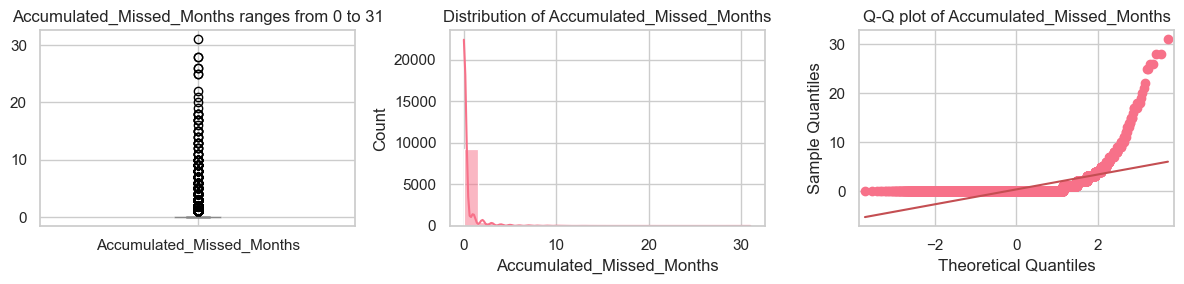

Written_Off


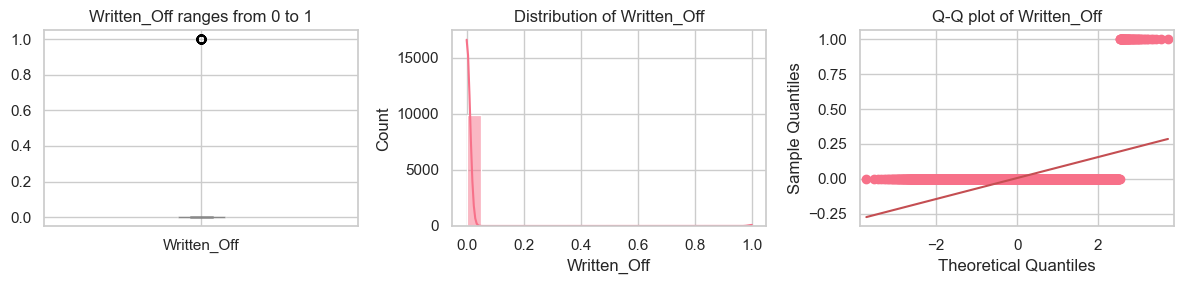

Time_to_Close


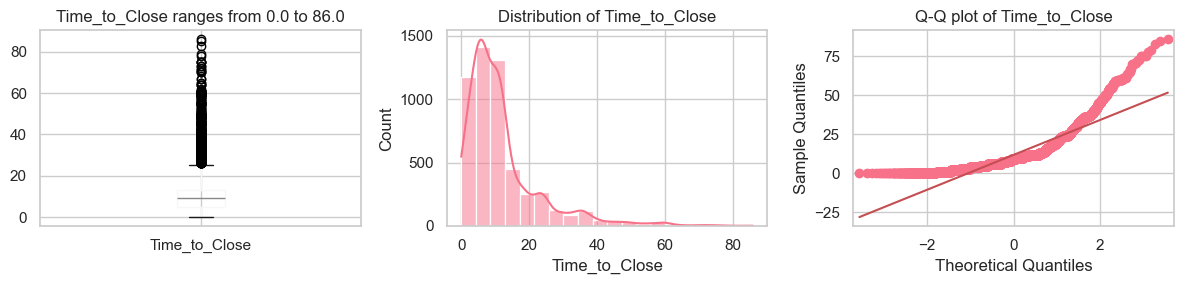

In [203]:
help_tool.distribution_check(bureau_balance_feature_matrix.drop(
    columns='SK_ID_BUREAU').sample(10000, random_state=42))

Customers with written off loans had longer periods until closing. AS seen by 95% Confidence intervals for 'Time_to_Close'

In [204]:
help_stats.confidence_intervals(
    bureau_balance_feature_matrix[bureau_balance_feature_matrix['Written_Off'] == 0]['Time_to_Close'], 'Discrete')

Confidence Interval: [11.64, 11.67]


In [205]:
help_stats.confidence_intervals(
    bureau_balance_feature_matrix[bureau_balance_feature_matrix['Written_Off'] == 1]['Time_to_Close'], 'Discrete')

Confidence Interval: [28.10, 28.77]


Conclusion: Written_Off will be used in next stages as it has information on customers defaulting.

# Bureau dataset
Dataset has information on all client's previous credits provided by other financial institutions that were reported to Credit Bureau. Dataset is made of 1.7 mill. observations and 17 features. Some features have empty values, but no duplicates.

In [206]:
bureau = help_tool.csv_download(r'Archive\home-credit-default-risk\bureau.csv')
help_tool.first_look(bureau)

Dataset has 1716428 observations and 17 features
Columns with all empty values []
Dataset has 0 duplicates


,dtypes,"Null values, Count","Null values, %"
SK_ID_CURR,int64,0,0.0
SK_ID_BUREAU,int64,0,0.0
CREDIT_ACTIVE,object,0,0.0
CREDIT_CURRENCY,object,0,0.0
DAYS_CREDIT,int64,0,0.0
CREDIT_DAY_OVERDUE,int64,0,0.0
DAYS_CREDIT_ENDDATE,float64,105553,6.1
DAYS_ENDDATE_FACT,float64,633653,36.9
AMT_CREDIT_MAX_OVERDUE,float64,1124488,65.5
CNT_CREDIT_PROLONG,int64,0,0.0


## EDA
### Categorical Features
* Most cases are Closed or Active. Credit activity will be imputed to preferable vs not preferable on numerical.
* CREDIT_TYPE will be grouped to 3 categories, as Consumer Credit and Credit Card make up more than 96 % together. (note that countplot below is showing dispersed percentages).
* Absolute majority of currency is '1'.

In [207]:
bureau_sample = bureau.sample(n=10000, random_state=42)

bureau_sample['CREDIT_ACTIVE'].value_counts()

CREDIT_ACTIVE
Closed    6349
Active    3614
Sold        37
Name: count, dtype: int64

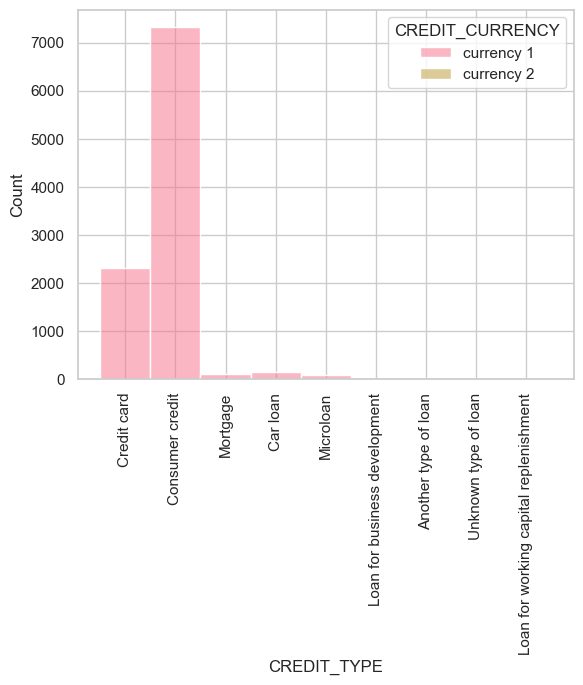

In [208]:
sns.histplot(data=bureau_sample, x='CREDIT_TYPE', hue='CREDIT_CURRENCY')
plt.xticks(rotation=90)
plt.show()

In [209]:
def bureau_clean(df):
    # Strip 'currency ' from CREDIT_CURRENCY and convert to int
    df['CREDIT_CURRENCY'] = df['CREDIT_CURRENCY'].str.lstrip(
        'currency ').astype(int)

    # Replace non-preferred CREDIT_TYPE values with 'Other'
    df['CREDIT_TYPE'] = df['CREDIT_TYPE'].where(
        df['CREDIT_TYPE'].isin(['Credit card', 'Consumer credit']), 'Other')

    # Map CREDIT_ACTIVE values to numerical scale
    credit_active_map = {'Closed': 2, 'Active': 1, 'Sold': -1, 'Bad debt': -1}
    df['CREDIT_ACTIVE'] = df['CREDIT_ACTIVE'].replace(
        credit_active_map).astype(int)


bureau_clean(bureau)

### Numerical Features

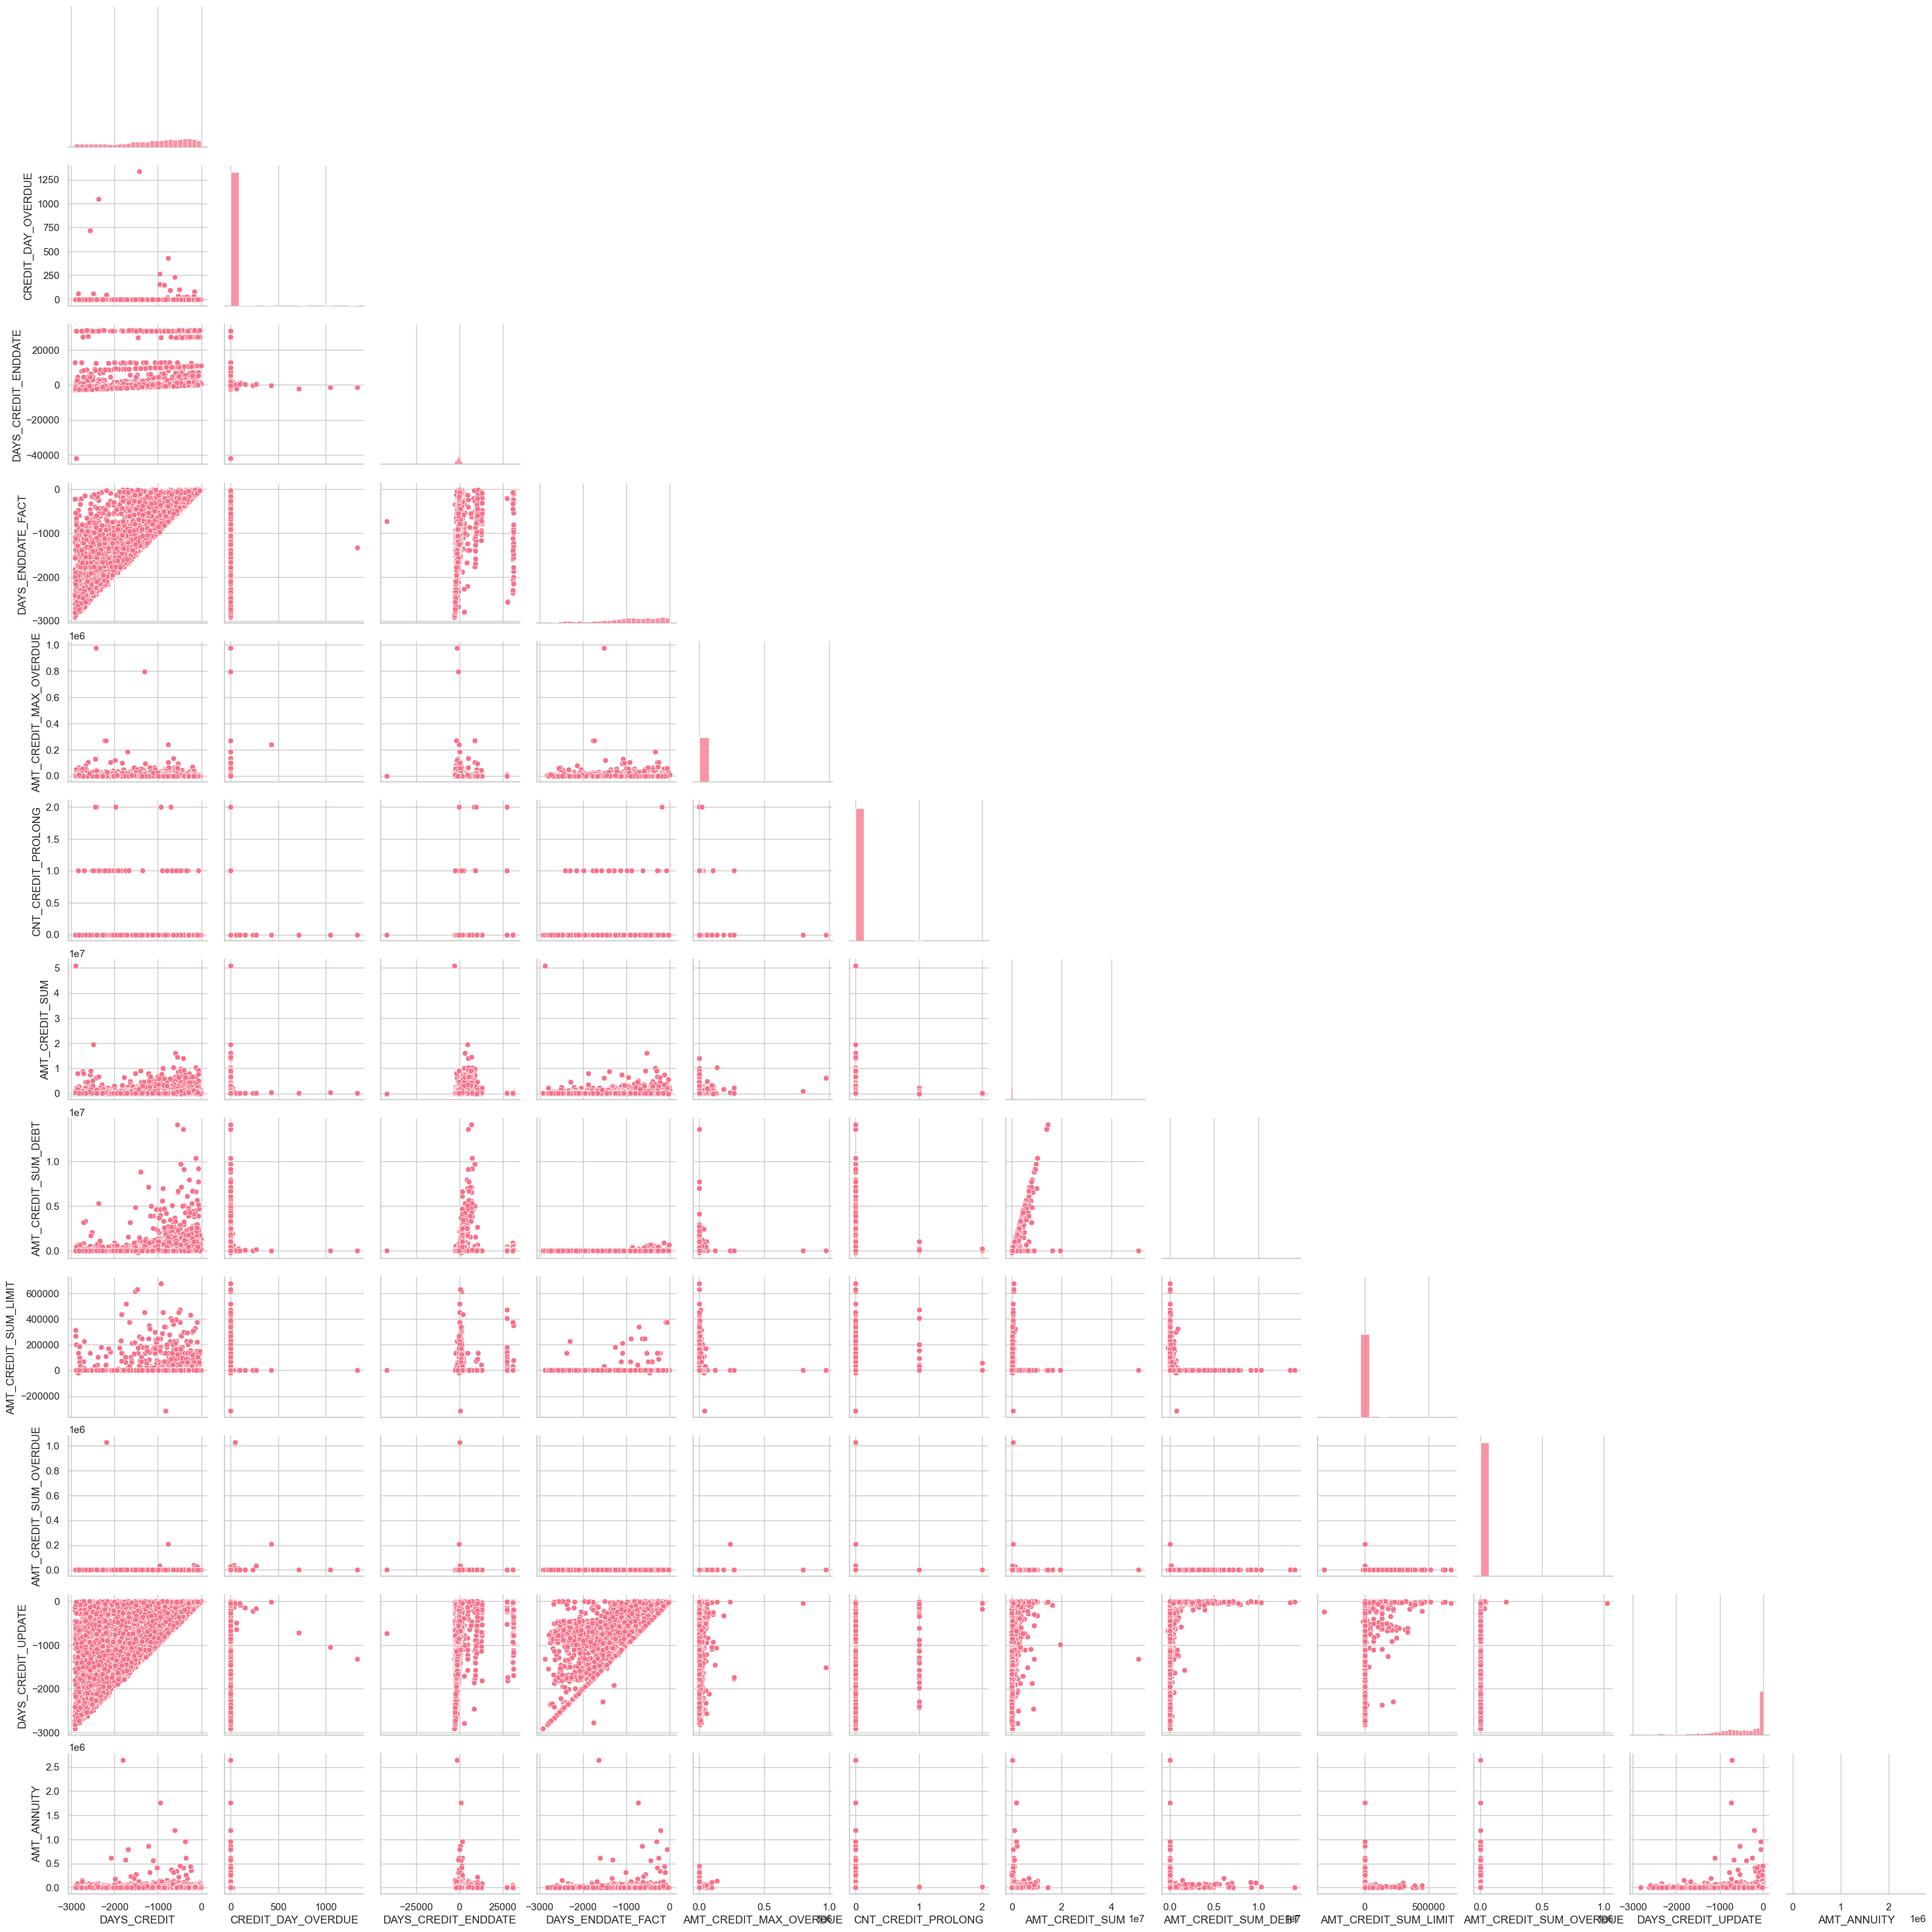

In [210]:
sns.pairplot(data=bureau_sample.drop(
    columns=['SK_ID_CURR', 'SK_ID_BUREAU']), corner=True)

plt.show()

No features look correlated, apart from AMT_CREDIT_SUM_DEBT and AMT_CREDIT_SUM, but even so there's difference of information each of the features bring. Instead, new Ratio features will be created.

## Feature engineering
Creating new features based on ratio and duration of related sets. Used features will be dropped.

In [211]:
bureau[[
    'Application_Duration', 'Update_Duration', 'Remaining_Duration',
    'RATIO_SUM_DEBT', 'RATION_SUM_LIMIT', 'RATION_SUM_OVERDUE'
]] = duckdb.query("""  
    SELECT
    (COALESCE(DAYS_ENDDATE_FACT, 0) - COALESCE(DAYS_CREDIT, 0)) AS Application_Duration,
    (COALESCE(DAYS_CREDIT_UPDATE, 0) - COALESCE(DAYS_CREDIT, 0)) AS Update_Duration,
    (COALESCE(DAYS_CREDIT_ENDDATE, 0) - COALESCE(DAYS_CREDIT, 0)) AS Remaining_Duration,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_DEBT) AS RATIO_SUM_DEBT,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_LIMIT) AS RATION_SUM_LIMIT,
    (AMT_CREDIT_SUM / AMT_CREDIT_SUM_OVERDUE) AS RATION_SUM_OVERDUE  

    FROM bureau
  """).to_df()

bureau.drop(columns=bureau.filter(
    like='DAYS', axis=1).columns.to_list(), inplace=True)
bureau.drop(columns=['AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
            'AMT_CREDIT_SUM_OVERDUE'], inplace=True)

# OneHotEncoding for categorical features
bureau_expanded = help_tool.dummy_columns(
    bureau, ['CREDIT_TYPE', 'CREDIT_ACTIVE'])

Combining bureau_balance and bureau data together.

In [212]:
bureau_combined = duckdb.query("""  
  SELECT A.*, B.Written_Off
  FROM bureau_expanded A 
  LEFT JOIN bureau_balance_feature_matrix B    
  ON A.SK_ID_BUREAU = B.SK_ID_BUREAU              
                      
  """).to_df()

bureau_combined.shape

(1716428, 18)

### Aggregated features with FeatureTools
FeatureTools created 69 features for min, max, sum, mean.

In [213]:
bureau_feature_matrix = help_model.aggregated_features(
    bureau_combined.drop(columns='SK_ID_BUREAU'), 'SK_ID_CURR')

bureau_feature_matrix.shape

(305811, 82)

# Selecting features baset on TARGET

In [214]:
application_train = help_tool.csv_download(
    r'Archive\home-credit-default-risk\application_train.csv')[['SK_ID_CURR', 'TARGET']]

In [215]:
app_bureau_feature_matrix = duckdb.query("""  
    SELECT A.*, B.TARGET
    FROM bureau_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

app_bureau_feature_matrix['TARGET'].value_counts(
) / app_bureau_feature_matrix['TARGET'].count() * 100

TARGET
0    92.269945
1     7.730055
Name: count, dtype: float64

#### Biserial correlation
Biserial correlation shows no correlation between created features and TARGET.

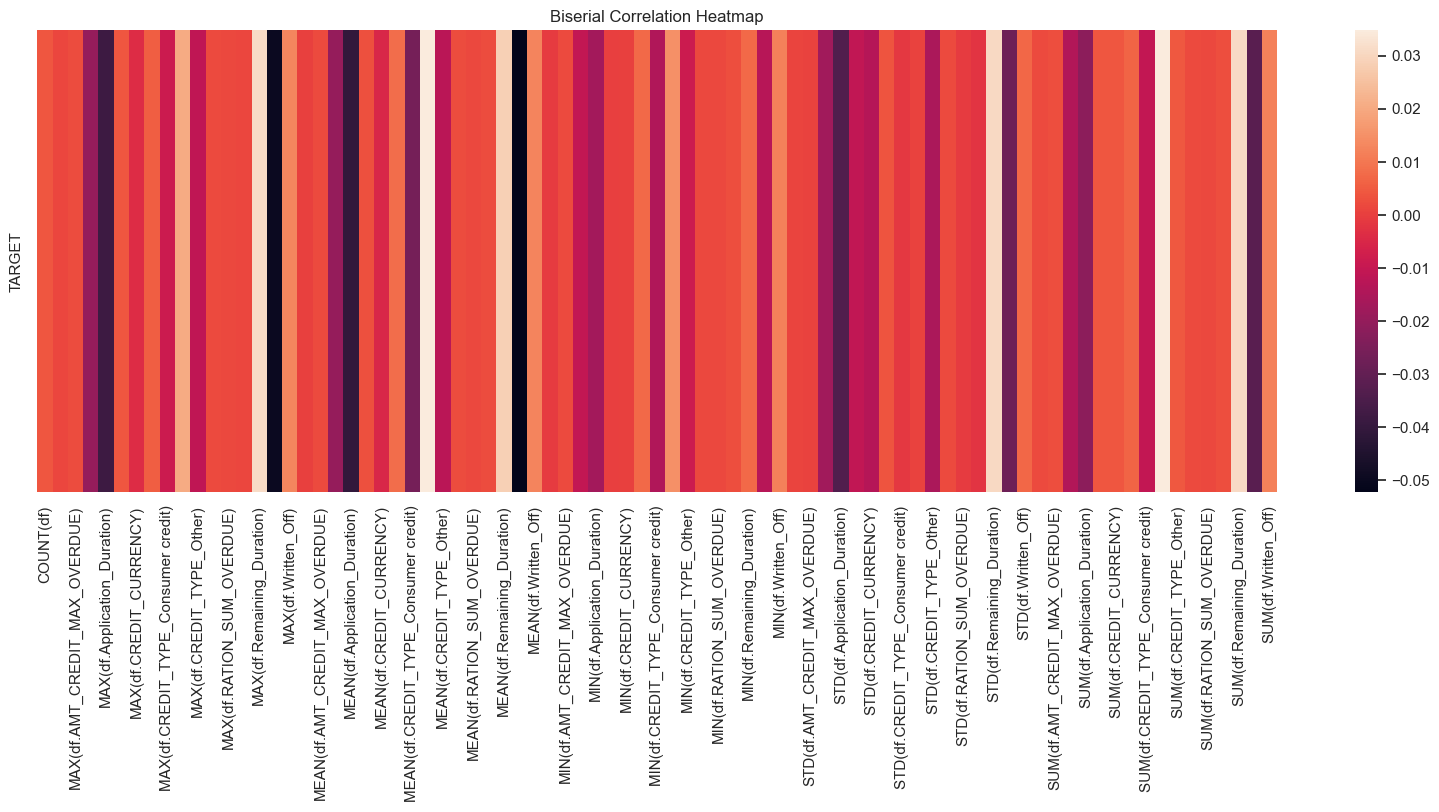

In [216]:
plt.figure(figsize=(20, 6))
help_stats.biserial_heatmap(app_bureau_feature_matrix.fillna(-1), app_bureau_feature_matrix.drop(
    columns=['SK_ID_CURR', 'TARGET']).columns.to_list(), ['TARGET'])

#### LightGBM
Using LightGBM for feature selection and importance.

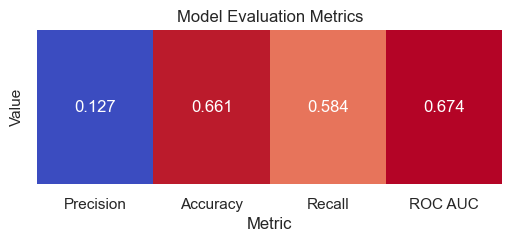

In [217]:
bureau_feature_importance = help_model.model_feature_importance_target(
    app_bureau_feature_matrix)

#### Top features

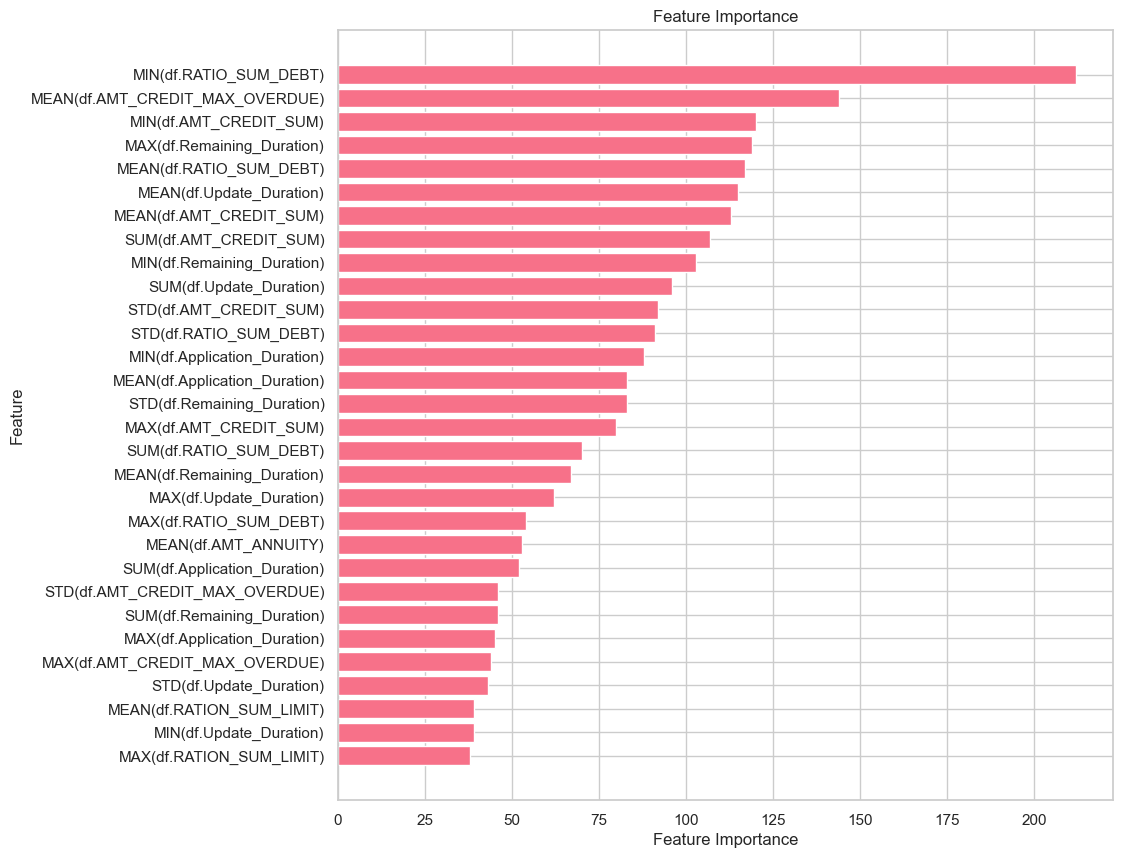

In [218]:
help_model.plot_feature_importance(bureau_feature_importance.head(30))

Top 6 features are not correlated ammong each other, apart from RATIO_SUM_DEBT. Mean feature will be removed.

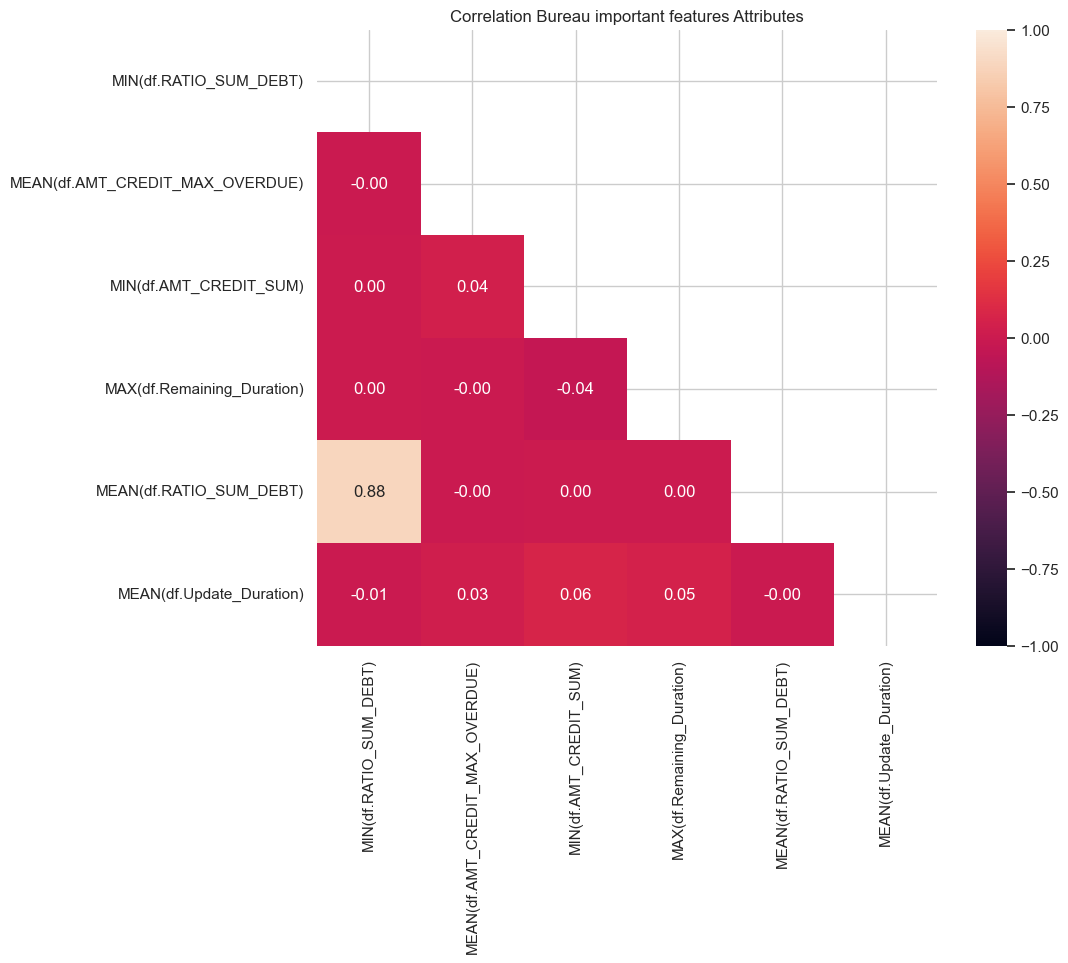

In [219]:
help_visuals.heatmap(app_bureau_feature_matrix[bureau_feature_importance.head(
    6)['feature'].to_list()], 'Bureau important features', 'pearson')

In [227]:
bureau_features = ['MIN(df.RATIO_SUM_DEBT)',
                   'MEAN(df.AMT_CREDIT_MAX_OVERDUE)',
                   'MIN(df.AMT_CREDIT_SUM)',
                   'MAX(df.Remaining_Duration)',
                   'MEAN(df.Update_Duration)']

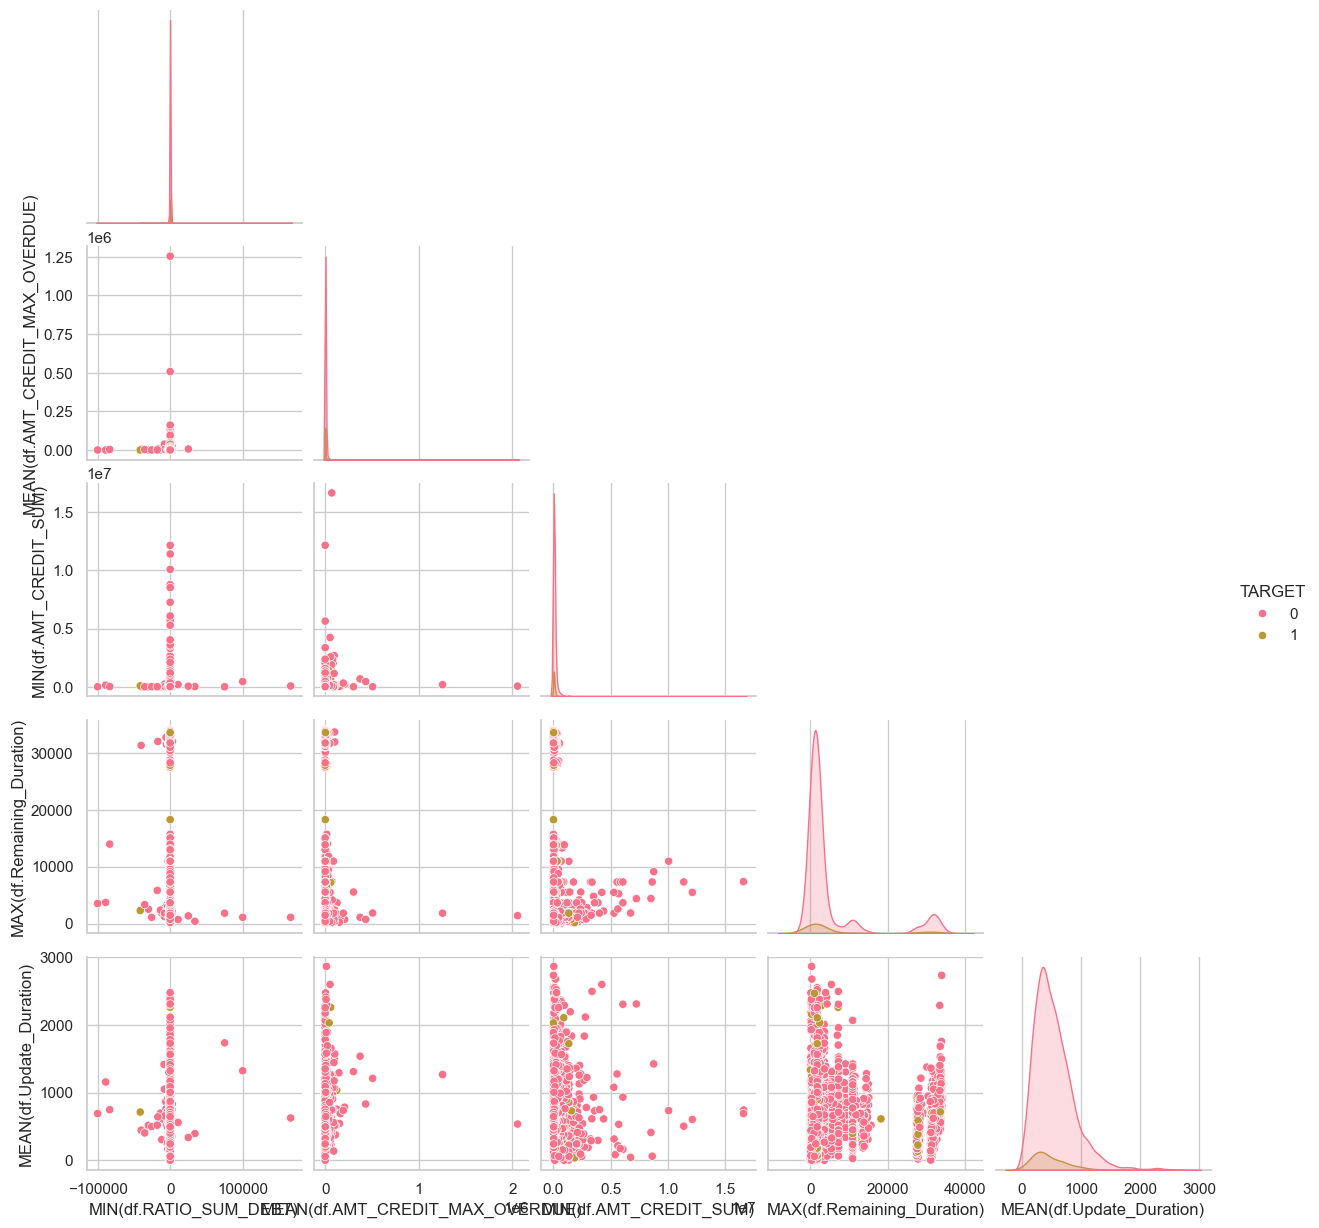

In [228]:
sns.pairplot(app_bureau_feature_matrix[bureau_features + ['TARGET']].sample(
    10000, random_state=42), hue='TARGET', corner=True)

plt.show()

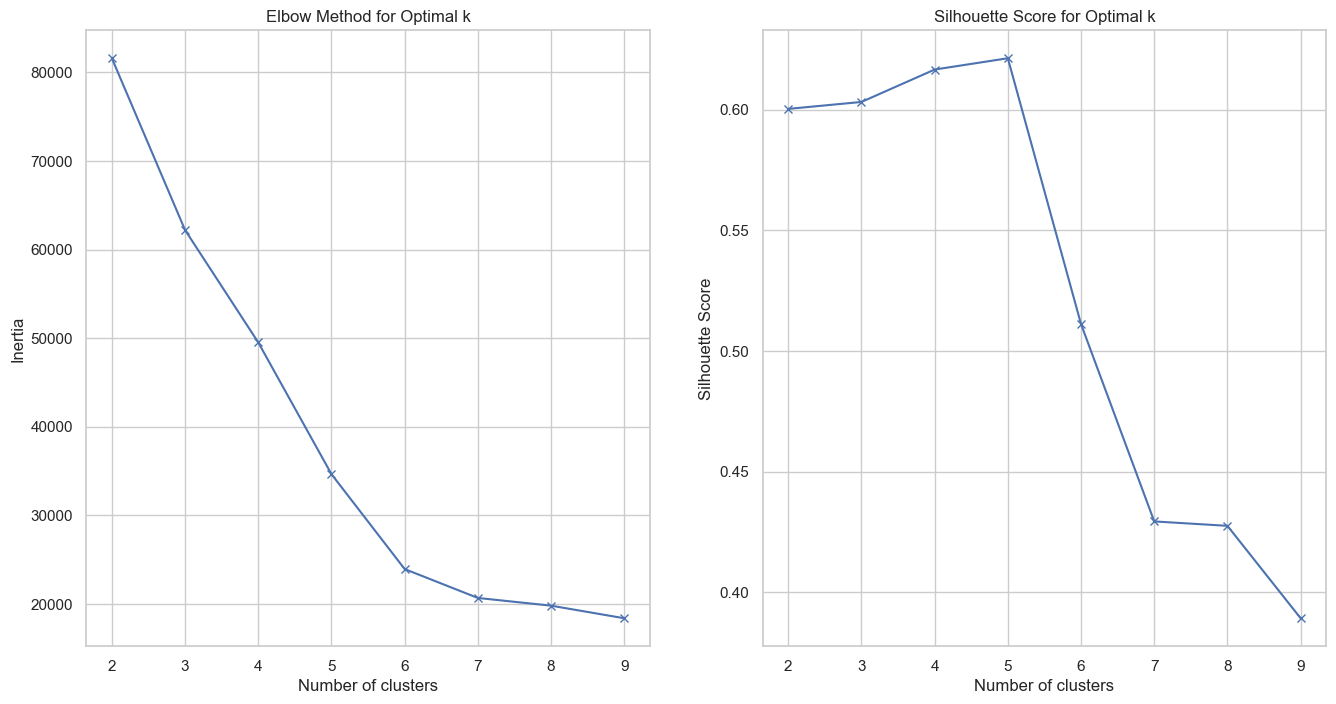

In [229]:
help_model.clustering_k_means_test(bureau_feature_matrix[bureau_features].sample(
    20000, random_state=42).fillna(bureau_feature_matrix[bureau_features].mean()))

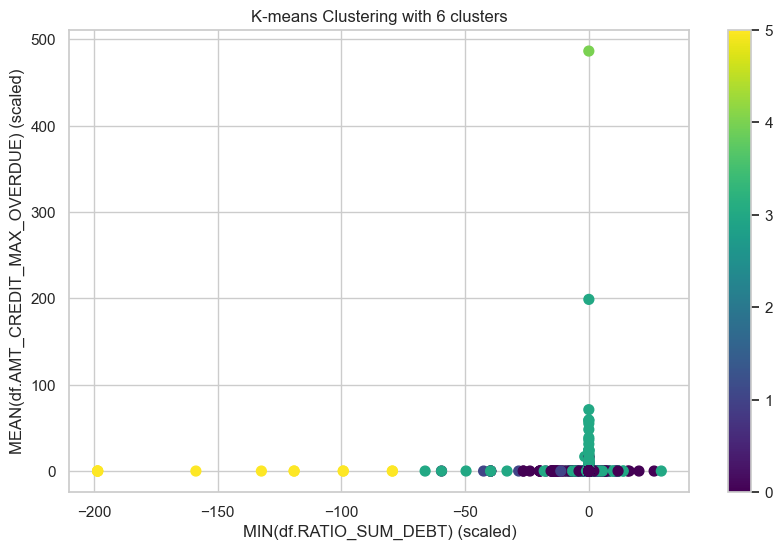

In [230]:
bureau_feature_matrix['Cluster_bureau'] = help_model.clustering_k_means(
    bureau_feature_matrix[bureau_features].fillna(bureau_feature_matrix[bureau_features].mean()), 6)

In [231]:
final_check = duckdb.query("""  
    SELECT A.Cluster_bureau, B.TARGET
    FROM bureau_feature_matrix A
    INNER JOIN application_train B
    ON A.SK_ID_CURR = B.SK_ID_CURR
  """).to_df()

final_check.value_counts() / final_check['Cluster_bureau'].value_counts() * 100

Cluster_bureau  TARGET
0               0          92.037682
3               0          94.282332
1               0          89.223939
0               1           7.962318
3               1           5.717668
1               1          10.776061
5               0         100.000000
2               0         100.000000
4               0         100.000000
Name: count, dtype: float64

Cluster 2, 5, 4 are always 'TARGET'=0, but other 3 can have 'TARGET'=1. Clusters with no positive values on 'TARGET' are going to be grouped.

In [234]:
bureau_feature_matrix.loc[bureau_feature_matrix['Cluster_bureau'].isin(
    [2, 4, 5]), 'Cluster_bureau'] = 2

In [235]:
sorted_bureau_feature_matrix = bureau_feature_matrix[[
    'SK_ID_CURR', 'Cluster_bureau']]

sorted_bureau_feature_matrix.to_csv(
    r'Archive\home-credit-default-risk\sorted_bureau_feature_matrix.csv')

# Conclusion
In this Notebook, behavior data from Bureau have been aggregated and clustered into groups of customer, which reflects ratio of debt, overdue amounts, credit sum.